Parts of Duffision model building:
1. Forward process
- Noise schedule (betas, alphas)
2. Denoising process
- UNET ( task specific blocks: time embeddings, residual connections, attention blocks)
- Additional image guidance
- LDM implementation (?)
3. Sampling
- Same UNET but using something on top to speed it up

#### Data and imports

In [1]:
! pip install diffusers
! pip install torchvision
! pip install einops

  Obtaining dependency information for einops from https://files.pythonhosted.org/packages/44/5a/f0b9ad6c0a9017e62d4735daaeb11ba3b6c009d69a26141b258cd37b5588/einops-0.8.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.5 MB/s eta 0:00:00


In [2]:
from einops import rearrange 
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 1, 6, 3, 4, 3, 9, 3])


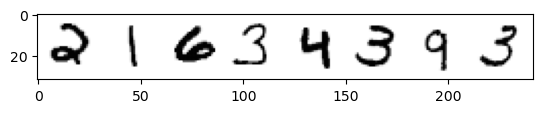

In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

#### Forward process

In [5]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

In [6]:
def linear_schedule(T, start = 0.0001, end = 0.02):
    return torch.linspace(start, end, T)

def cosine_schedule(T, s = 0.008):
        a_t_bar = torch.cos((torch.linspace(0,T, T+1) / T + s) / (1 + s) * 0.5 * torch.pi) ** 2
        a_t = a_t_bar[1:] / a_t_bar[:-1]
        return 1 - a_t


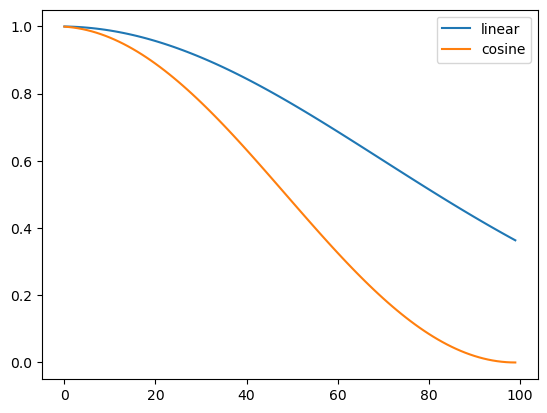

In [7]:
T = 100
a_bar_cosine = torch.cumprod(1 - cosine_schedule(T), dim = 0)
a_bar_linear = torch.cumprod(1 - linear_schedule(T), dim = 0)
plt.plot(a_bar_linear)
plt.plot(a_bar_cosine)
plt.legend(["linear", "cosine"])
plt.show()

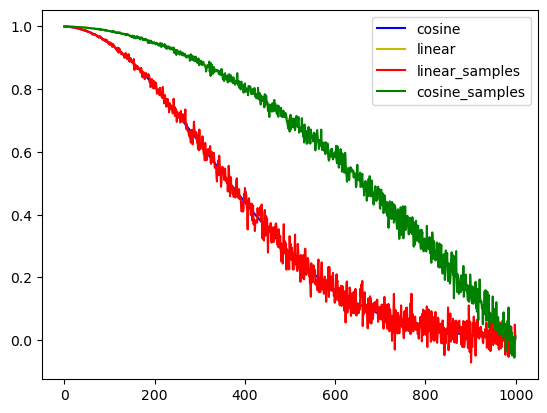

In [8]:
T = 1000

a_bar_linear = torch.cumprod(1- linear_schedule(T), dim= 0)
linear_samples = torch.stack([torch.normal(a_bar_linear**0.5, (1- a_bar_linear)) for i in range(1000)], dim = 0).mean(dim=0)

a_bar_cosine = torch.cumprod(1- cosine_schedule(T), dim= 0)
cosine_samples = torch.stack([torch.normal(a_bar_cosine**0.5, (1- a_bar_cosine)) for i in range(1000)], dim = 0).mean(dim=0)

plt.plot(a_bar_linear**0.5, color = 'b')
plt.plot(a_bar_cosine**0.5, color = 'y')
plt.plot(linear_samples, color = 'r')
plt.plot(cosine_samples, color = 'g')
plt.legend(['cosine','linear', 'linear_samples', 'cosine_samples'])
plt.show()

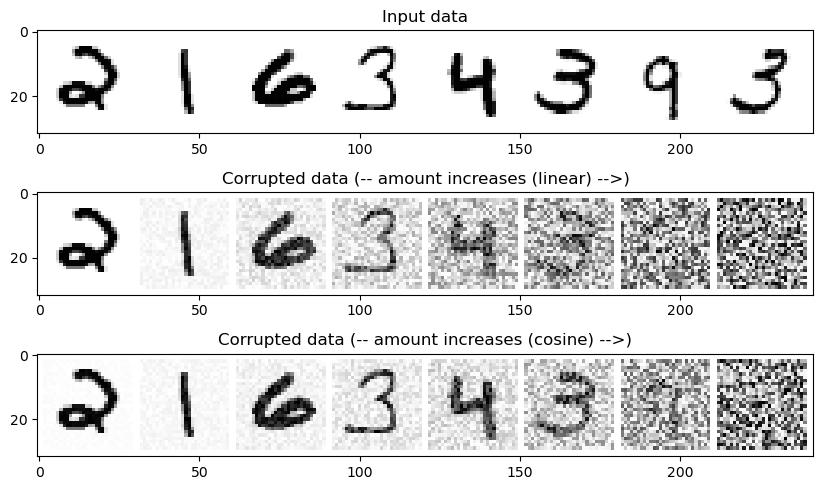

In [55]:
fig, axs = plt.subplots(3, 1, figsize=(18, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# Adding linear noise
amount_linear = linear_schedule(x.shape[0], end = 1) # Left to right -> more corruption
noised_x_linear = corrupt(x, amount_linear)

# Plotting the noised version
axs[1].set_title('Corrupted data (-- amount increases (linear) -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x_linear)[0], cmap='Greys');

# Adding linear noise
amount_cosine = cosine_schedule(x.shape[0]) # Left to right -> more corruption
noised_x_cosine = corrupt(x, amount_cosine)

# Plotting the noised version
axs[2].set_title('Corrupted data (-- amount increases (cosine) -->)')
axs[2].imshow(torchvision.utils.make_grid(noised_x_cosine)[0], cmap='Greys');
plt.tight_layout()

#### U-Net

In [56]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.05):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.conv(x)

In [74]:
class AttentionBlock(nn.Module):
    def __init__(self, C: int, num_heads:int = 4 , dropout_prob: float = 0.05):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:] # extracting height and width
        x = rearrange(x, 'b c h w -> b (h w) c') # falttening image L = h*w
        x = self.proj1(x) # linear layer two increase amount of channels by a factor of 3 
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads) # divide channels into 3 parts (Q,K,V) and distribute to K attention heads
        q,k,v = x[0], x[1], x[2] # Reassignment
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob) # dot product attention
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w) # reshape to initial batch, height, width, channels
        x = self.proj2(x) # Linear layer on top 
        return rearrange(x, 'b h w C -> b C h w') # rearrange to PyTorch familiar shape

In [46]:
a = TimeEmbedding(10)

a(x, t)

tensor([[[[-0.5064]],

         [[-0.5148]],

         [[-0.1405]],

         [[ 0.9997]],

         [[ 0.5889]],

         [[ 0.5403]],

         [[ 0.3877]],

         [[ 0.9875]],

         [[ 0.0631]],

         [[ 0.9997]]],


        [[[-0.5064]],

         [[-0.5148]],

         [[-0.1405]],

         [[ 0.9997]],

         [[ 0.5889]],

         [[ 0.5403]],

         [[ 0.3877]],

         [[ 0.9875]],

         [[ 0.0631]],

         [[ 0.9997]]],


        [[[-0.5064]],

         [[-0.5148]],

         [[-0.1405]],

         [[ 0.9997]],

         [[ 0.5889]],

         [[ 0.5403]],

         [[ 0.3877]],

         [[ 0.9875]],

         [[ 0.0631]],

         [[ 0.9997]]],


        [[[-0.5064]],

         [[-0.5148]],

         [[-0.1405]],

         [[ 0.9997]],

         [[ 0.5889]],

         [[ 0.5403]],

         [[ 0.3877]],

         [[ 0.9875]],

         [[ 0.0631]],

         [[ 0.9997]]],


        [[[-0.5064]],

         [[-0.5148]],

         [[-0.1405]],

   

In [ ]:
x + torch.rand([8, 1])[:,:,None,None]

In [65]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x, t):
        encoding = torch.zeros(self.dim)
        sin_part = torch.sin(t / 10000 ** (torch.arange(0, self.dim, 2, device=x.device) / self.dim))
        cos_part = torch.cos(t / 10000 ** (torch.arange(1, self.dim, 2, device=x.device) / self.dim))
        encoding[::2] = sin_part
        encoding[1::2] = cos_part
        # add batch size and channel dims
        encoding = encoding.repeat(x.shape[0], 1)
        return encoding[:,:, None, None]

In [86]:
class DiffUNet(nn.Module):
    def __init__(self, in_channels=1, 
                 out_channels=1,
                 num_heads = 8,

                 ):
        super().__init__()
        self.conv1 = ConvBlock(1, 32)
        self.conv2 = ConvBlock(32, 64) 
        self.conv3 = ConvBlock(64, 128)

        self.attn1 = AttentionBlock(64, num_heads=num_heads)

        self.conv4 = ConvBlock(256, 128)
        self.conv5 = ConvBlock(128, 64)
        self.conv6 = ConvBlock(64, 32)

        self.attn2 = AttentionBlock(64, num_heads=num_heads)

        self.lastconv = nn.Conv2d(32, 1, kernel_size=3, padding=1)

        self.middleconv = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upscale1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upscale2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

        self.timeemb = TimeEmbedding(32)

    def forward(self, x, t):
        x1_down = self.conv1(x)
        x1_down += self.timeemb(x, t)
        x2_down = self.conv2(self.maxpool(x1_down))
        x2_down = self.attn1(x2_down)
        x3_down = self.conv3(self.maxpool(x2_down))

        h = self.middleconv(x3_down)

        x1_up = self.conv4(torch.cat((h, x3_down), dim=1))
        x2_up = self.conv5(torch.cat((self.upscale1(x1_up), x2_down), dim=1))
        x2_up = self.attn2(x2_up)
        x3_up = self.conv6(torch.cat((self.upscale2(x2_up), x1_down), dim=1))
        output = self.lastconv(x3_up)
        
        return output

        
        

In [89]:
net = DiffUNet()
x = torch.rand(8, 1, 28, 28)
net(x, 3).shape

torch.Size([8, 1, 28, 28])

In [90]:
sum([p.numel() for p in net.parameters()])

1091489

In [91]:
sum([p.numel() for p in net.parameters()])

1091489

### Training

In [92]:
#progress bar import
from tqdm.notebook import tqdm

In [96]:
T = 10
noise_schedule = cosine_schedule(T)

In [97]:
# Get some data and prepare the corrupted version
x = x.to(device) # Data on the GPU
noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
noisy_x = corrupt(x, noise_amount) # Create our noisy x

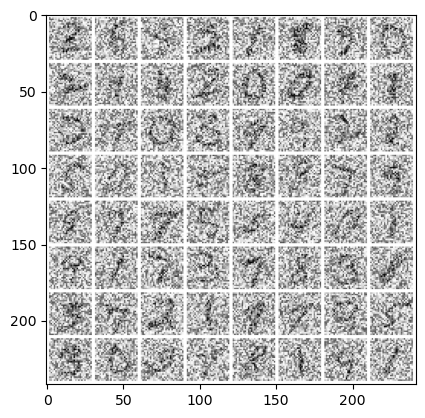

In [106]:
plt.imshow(torchvision.utils.make_grid(corrupt(x, eps))[0], cmap='Greys');

In [105]:
t = 8

eps = noise_schedule[t]

corrupt(x, eps)

tensor([[[[1.0053e-01, 4.3956e-01, 5.2162e-01,  ..., 3.1113e-01,
           1.5812e-01, 1.7796e-01],
          [5.9212e-01, 6.8768e-01, 9.0980e-02,  ..., 6.7357e-01,
           7.3388e-01, 6.6788e-01],
          [6.5118e-01, 3.8756e-01, 5.9318e-01,  ..., 6.7542e-01,
           6.1158e-02, 5.4753e-01],
          ...,
          [3.3686e-01, 1.5814e-01, 5.5407e-01,  ..., 1.9036e-01,
           3.4499e-01, 2.8348e-01],
          [6.2434e-02, 4.1883e-01, 2.7081e-01,  ..., 6.7690e-01,
           4.1420e-01, 3.1393e-01],
          [4.7619e-01, 6.9606e-03, 7.2099e-01,  ..., 6.6940e-01,
           1.2387e-01, 6.7703e-01]]],


        [[[4.6565e-01, 5.5626e-01, 4.4037e-01,  ..., 6.8862e-01,
           9.8841e-02, 2.3187e-01],
          [3.3916e-01, 1.3140e-01, 3.8697e-02,  ..., 2.5863e-02,
           5.2821e-01, 6.3532e-01],
          [3.5419e-01, 2.9600e-01, 5.4460e-01,  ..., 2.1115e-01,
           3.8002e-01, 2.7016e-01],
          ...,
          [2.3990e-01, 5.5495e-01, 3.3890e-01,  ..., 7.17

In [115]:
# Dataloader (you can mess with batch size)
batch_size = 64
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = DiffUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

a_bar = torch.cumprod(1- cosine_schedule(T), dim= 0).to(device)

# The training loop
for epoch in range(n_epochs):
    for t in range(T):
    
        a_bar_t = a_bar[t]

        for x, y in tqdm(train_dataloader):

            # Get some data and prepare the corrupted version
            x = x.to(device) # Data on the GPU

            eps = torch.randn_like(x, requires_grad=False)
            
            noisy_x = (torch.sqrt(a_bar_t)*x) + (torch.sqrt(1-a_bar_t)*eps)


            # Get the model prediction
            pred = net(noisy_x, t)

            # Calculate the loss
            loss = loss_fn(pred, eps)

            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Store the loss for later
            losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    # View the loss curve
    plt.plot(losses)
    plt.ylim(0, 0.1);

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

Sources of inspiration:

- https://github.com/huggingface/diffusion-models-class
- https://nn.labml.ai/diffusion
- https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/model.py

